# This is the code for anchor box clustering

In [1]:
''' import modules '''
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from itertools import chain

%matplotlib inline

In [2]:
'''annotation file (a text file generated from the JSON) for thermal training images 
   see the 'labels' directory for JSON to text conversion
   the converted text files are saved in labels/annotations
'''
directory = '../labels/annotations'
fname = 'annotations_thermal_train'
train_annot = os.path.join(directory, f"{fname}.txt")
#   

In [3]:
''' the images are 640 x 512
    specify the target size at which to cluster
'''
source_size = (640, 512)   # (W, H)
target_size = 640          # target size of the largest dimension
                           # in this case the width
    
# calculate the ratio
ratio = float(target_size) / max(source_size)
# however, if you have a dataset with variable image diemsnions
# then you have to do this inside the loop below and also read
# each images to find source_size

In [4]:
''' read the lines from the text file and populated a list
    with all the bounding boxes
    also, populating the category for each box,
    in case, some one wants to cluster each category separately

'''
boxes = []
labels = []
num_attr = 7   # see comment below
with open(train_annot) as f:        
    
    lines  = f.readlines()
    #
    for line in lines:
        ''' first entry on each line is the image name
            if the image does not have any annotated objects
            that's all this line will have
        '''
        splited = line.strip().split()
        
        # skip if no object exists
        if len(splited) == 1:
            continue
        
        # else, count the number of objects and enter them to the list
        ''' each box has 7 entries:
            occlusion | truncation | x | y | x2 | y2 | category
        '''
        num_boxes = (len(splited) - 1) // num_attr
        box = []
        label = []
        for i in range(num_boxes):
            '''coordinates'''
            x1 = float(splited[3 + num_attr * i])
            y1 = float(splited[4 + num_attr * i])
            x2 = float(splited[5 + num_attr * i])
            y2 = float(splited[6 + num_attr * i])
            '''class'''
            c = splited[num_attr + num_attr * i]
            
            if int(c) > - 1:
                box.append([ratio * (x2 - x1), ratio * (y2 - y1)])
                label.append(int(c) + 1)         # 1-indexed
        
        boxes.append(box)
        labels.append(label)

In [5]:
boxes = np.array(list(chain(*boxes)))
labels = np.array(list(chain(*labels)))
wh = np.array(boxes)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (169013, 2)


#### The codes below were contributed by someone else on the web. I forgot to note the source, hence could not credit properly. My apologies for the oversight

In [6]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    #np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters
        
    return clusters,nearest_clusters,distances

#### The kmeans clustering below fails sometimes (it will throw bunch of warning). In that case, stop the kernal and run the cell again

In [7]:
wh = boxes
kmax = 15
dist = np.mean
results = {}
for k in range(2,kmax+1):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4117
 3 clusters: mean IoU = 0.4776
 4 clusters: mean IoU = 0.5095
 5 clusters: mean IoU = 0.5312
 6 clusters: mean IoU = 0.5656
 7 clusters: mean IoU = 0.5832
 8 clusters: mean IoU = 0.6150
 9 clusters: mean IoU = 0.6261
10 clusters: mean IoU = 0.6451
11 clusters: mean IoU = 0.6580
12 clusters: mean IoU = 0.6661
13 clusters: mean IoU = 0.6766
14 clusters: mean IoU = 0.6811
15 clusters: mean IoU = 0.6978


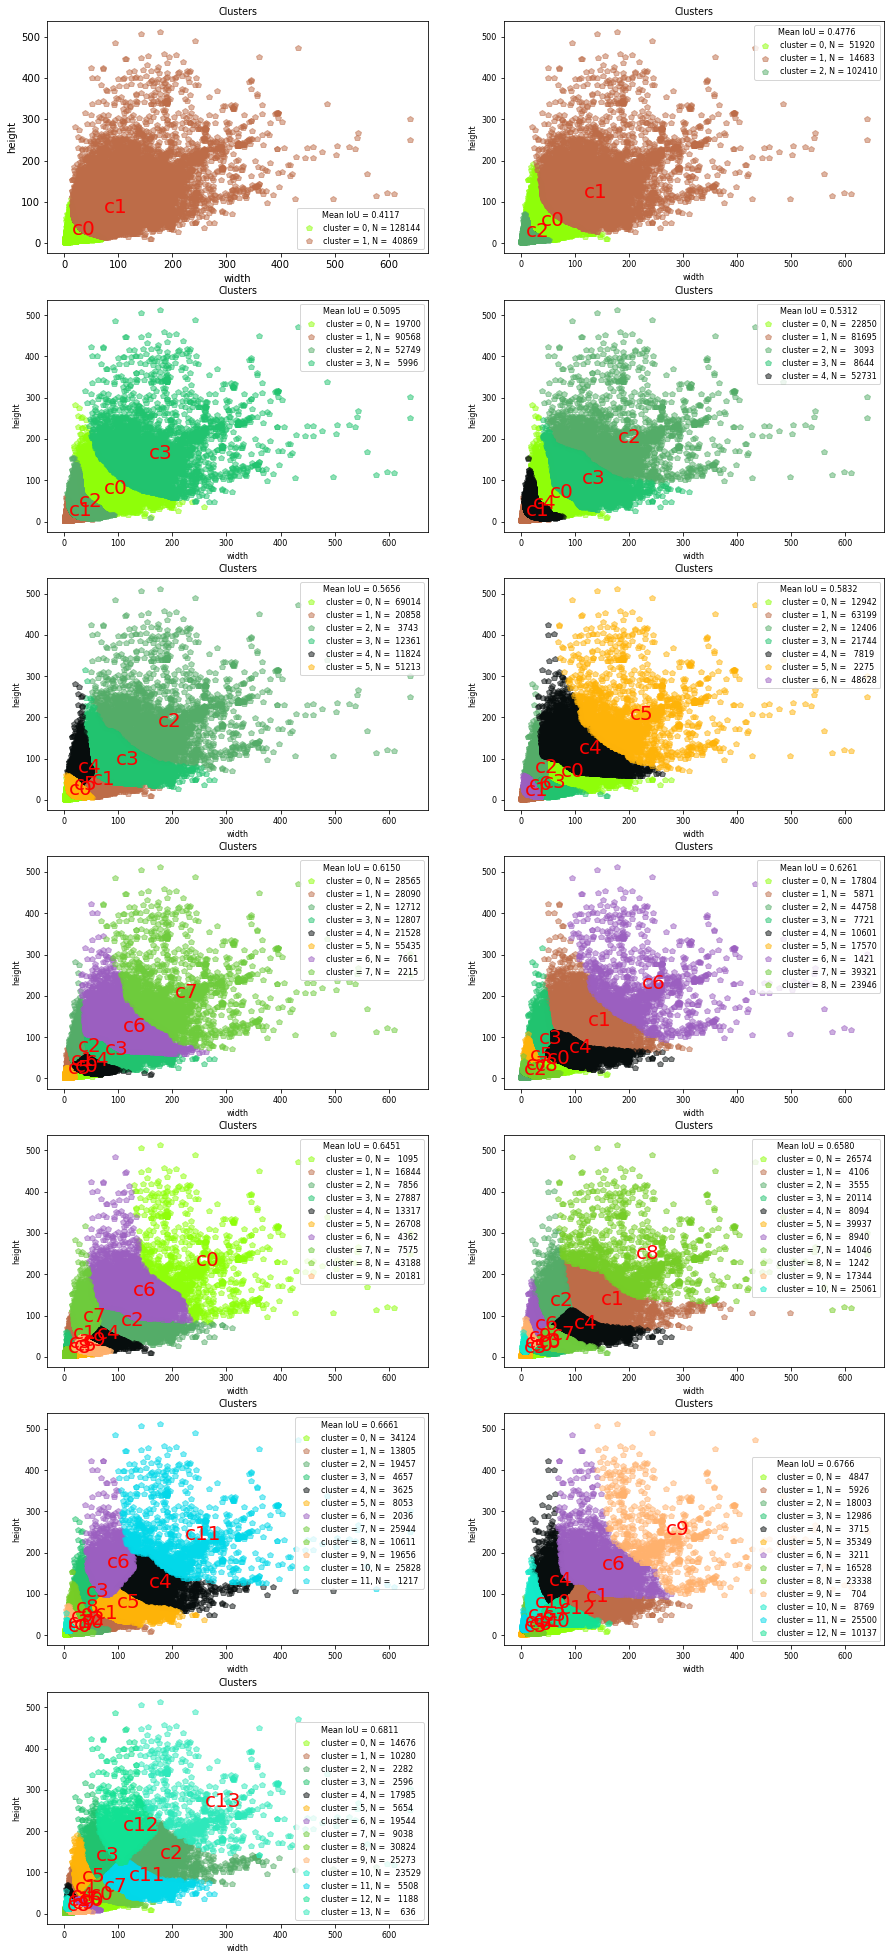

In [8]:
''' you can plot the clusters, 
    although I do not find them too useful
'''
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

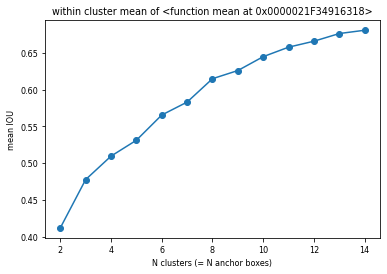

In [9]:
''' you will see as the number of clusters increses,
    the mean IoU saturates
'''
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

#### Now take the clusters for k = 15 (since I am using 5 anchors per scale and we have 3 scales). Alternatively, if you want only 3 anchors per scale, then use k = 9

In [10]:
k = 15
cluster_ctr = results[k]['clusters']
''' sort your anchors according to their area '''
cluster_ctr_area = cluster_ctr[:,0] * cluster_ctr[:,1]
cluster_ctr_sorted = cluster_ctr[np.argsort(cluster_ctr_area)].astype(np.int)
print(cluster_ctr_sorted)

[[  5   7]
 [  7  17]
 [ 12  10]
 [ 11  29]
 [ 19  18]
 [ 37  14]
 [ 18  48]
 [ 32  29]
 [ 57  38]
 [ 32  77]
 [ 80  60]
 [ 62 138]
 [131  85]
 [157 165]
 [273 244]]


#### You will now assign the 5 smallest anchors to the smallest prediction scale  (largest output feature map) and so on for training

### If one wishes to cluster individual categories separately, for example, for the category 2, then she/he could do it by assigning wh = boxes[labels == 2] in cell 8 and repeat the clustering process for each category
##### I have found this approch useful when you have only a handful of categories